In [8]:
import os, re
import pandas as pd
import numpy as np
from tqdm import tqdm
from typing import Union
from nltk.tokenize import sent_tokenize
from matplotlib import pyplot as plt
from utils import sectioned_clean_text, ENWIKI_LOC, NLWIKI_LOC, NLNEWS_LOC, NLAUVI_LOC_C, NLAUVI_LOC_N

### Datasets Analysis

* sections per doc
* sentences per doc
* sentences per section
* avg words per sentence per doc

In [25]:
def reject_outliers(data: Union[list, np.array], m=2):
    if isinstance(data, list):
        data = np.array(data, dtype=int)
    d = np.abs(data - np.median(data))
    mad = np.median(d) # Median Absolute Deviation
    s = d/mad if mad else 0.
    return data[s<m].flatten()

In [4]:
bases = {
    'ENWiki_dir': ENWIKI_LOC,
    'NLWiki_dir': NLWIKI_LOC,
    'NLNews_dir': NLNEWS_LOC, 
    'NLAuVi_C_dir': NLAUVI_LOC_C,
    'NLAuVi_N_dir': NLAUVI_LOC_N
}
metrics = [
    'Sections/Doc',
    'Sentences/Doc',
    'Sentences/Section',
    'Mean Words per Sentences/Doc'
]
table = pd.DataFrame(
    [[[] for _ in range(len(metrics))] for _ in range(len(bases.keys()))], # Initializes empty lists for each cell
    index=bases.keys(), columns=metrics
)
table

,Sections/Doc,Sentences/Doc,Sentences/Section,Mean Words per Sentences/Doc
ENWiki_dir,[],[],[],[]
NLWiki_dir,[],[],[],[]
NLNews_dir,[],[],[],[]
NLAuVi_C_dir,[],[],[],[]
NLAuVi_N_dir,[],[],[],[]


In [10]:
# Fill in the table
for dataset, dir in tqdm(bases.items(), desc='Datasets processed'):
    for root, _, files in os.walk(dir):
        for file in tqdm(files, leave=False, desc='Files processed'):
            with open(os.path.join(root, file), 'r', encoding='utf-8') as f:
                try:
                    doc = f.read()
                except UnicodeDecodeError:
                    continue
            sections = sectioned_clean_text(doc)
            sections_count = len(sections)
            if sections_count < 2:
                continue
            table.loc[dataset, metrics[0]].append(sections_count)
            # Count sentences
            sent_total = 0
            word_sent_count = []
            for section in sections:
                section_sep = sent_tokenize(section)
                sent_count = len(section_sep)
                table.loc[dataset, metrics[2]].append(sent_count)
                sent_total += sent_count
                # Count words
                for sent in section_sep:
                    word_sent_count.append(len(sent.split()))
            table.loc[dataset, metrics[1]].append(sent_total)
            table.loc[dataset, metrics[3]].append(np.mean(word_sent_count))

Datasets processed: 100%|██████████| 5/5 [37:17<00:00, 447.54s/it]   


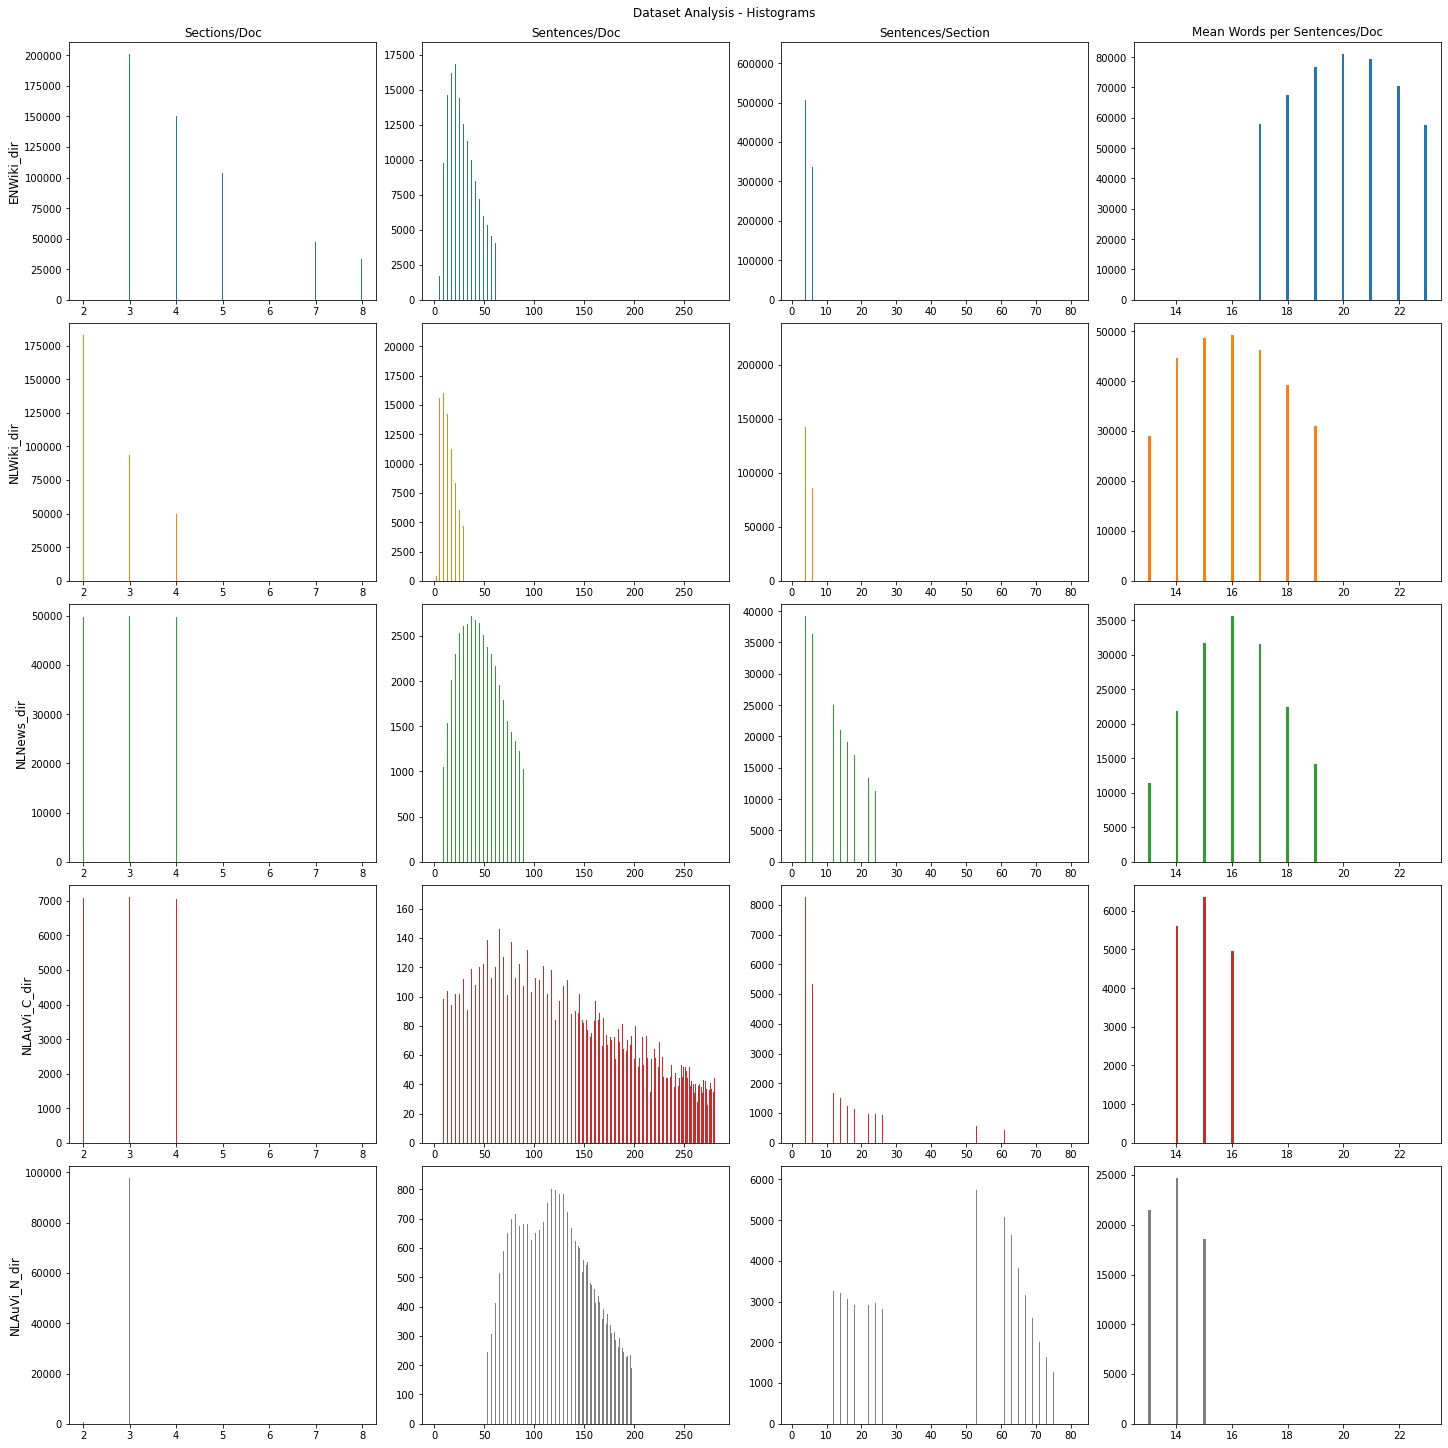

In [31]:
# Plot the stuff
table_adj = table.applymap(reject_outliers) # Remove outliers
colours = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:gray']
fig, axs = plt.subplots(nrows=len(bases), ncols=len(metrics), figsize=(20, 20))
for col, metric in enumerate(metrics):
    bins = np.histogram_bin_edges(np.hstack(table_adj[metric]), bins='auto')
    for row, dataset in enumerate(table_adj.index):
        if row == 0:
            axs[row, col].set_title(metric)
        if col == 0:
            axs[row, col].set_ylabel(dataset, size='large')
        axs[row, col].hist(table_adj.loc[dataset, metric], bins=bins, color=colours[row])

fig.suptitle('Dataset Analysis - Histograms')
fig.execute_constrained_layout()
# fig.tight_layout()
fig.show()

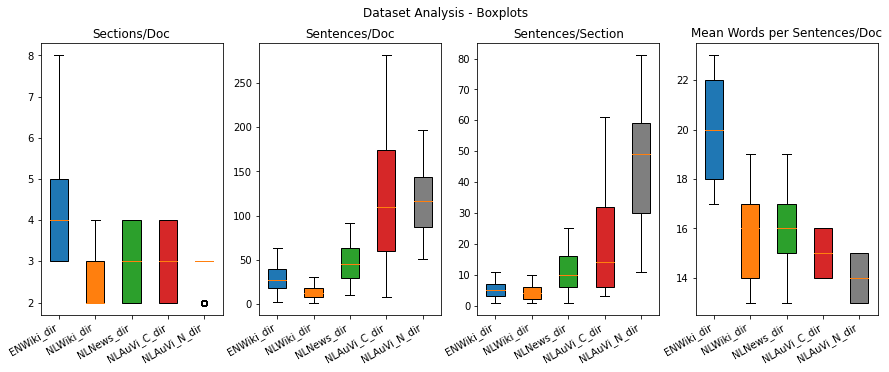

In [33]:
fig, axs = plt.subplots(1, len(metrics), figsize=(15,5))
for metric, ax in zip(metrics, axs):
    bplot = ax.boxplot(table_adj[metric], patch_artist=True)
    for patch, colour in zip(bplot['boxes'], colours):
        patch.set_facecolor(colour)
    ax.set_title(metric)
    ax.set_xticklabels(table_adj.index, rotation=30, ha='right')

fig.suptitle('Dataset Analysis - Boxplots')
# fig.execute_constrained_layout()
fig.show()

In [34]:
table_avg = table_adj.applymap(np.mean)
table_avg['Total'] = [len(x) for x in table['Sections/Doc']]
table_avg.round(2)

,Sections/Doc,Sentences/Doc,Sentences/Section,Mean Words per Sentences/Doc,Total
ENWiki_dir,4.53,29.80,5.13,20.01,727746
NLWiki_dir,2.59,14.22,4.32,15.97,390709
NLNews_dir,3.00,47.49,10.90,16.05,199023
NLAuVi_C_dir,3.00,119.82,20.14,14.96,28217
NLAuVi_N_dir,2.99,117.82,45.18,13.95,98530
